In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from math import factorial
import pylab
pylab.rcParams['figure.figsize'] = (10, 6)

In [2]:
#
#
# This is a continuation of the data exploration started in summary_all.ipynb. The first
# notebook considered the data on the largest scale, aggregating all customers together.
# We now want to understand exactly what the customer data looks like to get a sense of how
# we can use it to make predictions.
#
#

In [3]:
print "Reading prior orders data ... ",
order_prior = pd.read_csv('order_products__prior.csv')
orders = pd.read_csv('orders.csv')
print "done."

Reading prior orders data ...  done.


In [4]:
#
# What does the training data look like?
#

# group entries by order (aka "basket")
op_by_oid = order_prior.groupby('order_id')

# group orders by user
orders_by_uid = orders.groupby('user_id') 
# careful: do you want these to include "test" or "train"?
norders_by_uid = orders_by_uid.apply(len)

In [5]:
# basic summary statistics
nusers = len(orders_by_uid)
norders = len(op_by_oid)
max_ord = max(norders_by_uid)
min_ord = min(norders_by_uid)
pctiles = list(norders_by_uid.quantile([0.1, 0.5, 0.9]))
print "Total orders:", norders
print "Total users:", nusers
print "\tFor training:", len(set(orders[orders['eval_set'] == 'train']['user_id']))
print "\tFor testing:", len(set(orders[orders['eval_set'] == 'test']['user_id']))
print "Min orders per user:", min_ord
print "Max orders per user:", max_ord
print "Percentiles:"
print "\t10:", pctiles[0]
print "\t50:", pctiles[1]
print "\t90:", pctiles[2]
print "Avg number of orders: %.3f" % norders_by_uid.mean()

Total orders: 3214874
Total users: 206209
	For training: 131209
	For testing: 75000
Min orders per user: 4
Max orders per user: 100
Percentiles:
	10: 4.0
	50: 10.0
	90: 38.0
Avg number of orders: 16.590


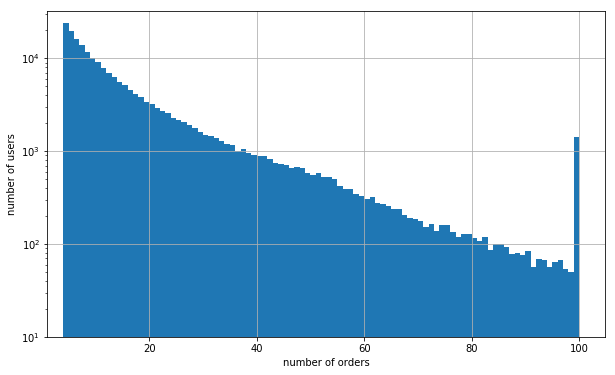

In [79]:
ax = pylab.gca()
n, bins, patches = pylab.hist(norders_by_uid, bins = max_ord - min_ord, log = True)
pylab.xlabel('number of orders')
pylab.ylabel('number of users')
pylab.xlim(xmin=1)
pylab.ylim(ymin=10)
pylab.grid()
pylab.show(ax)

In [17]:
#
# FIXME: Comment on plot
#

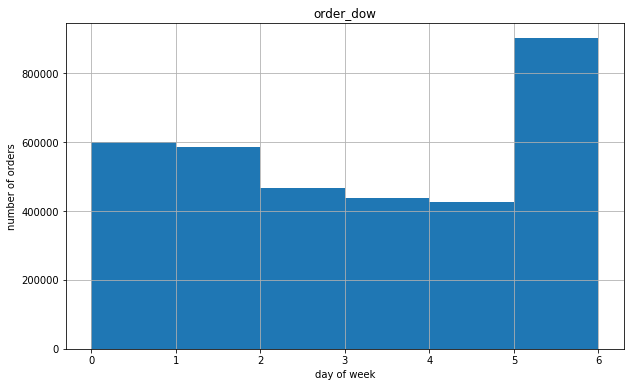

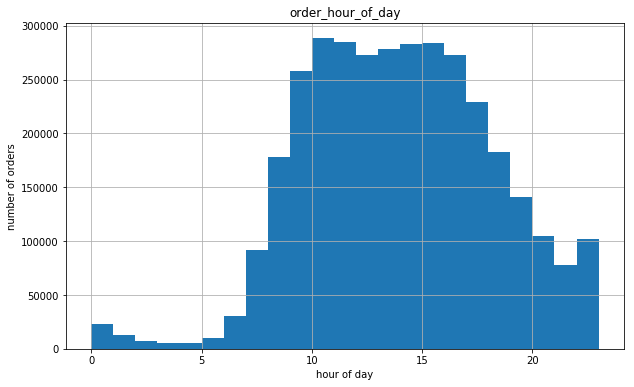

In [87]:
# I'm curious about the time-dependence of the data. Do we get more orders on
# certain days??
orders.hist(column='order_dow', bins=[0,1,2,3,4,5,6])
pylab.xlabel('day of week')
pylab.ylabel('number of orders')
pylab.show()
pylab.clf()

orders.hist(column='order_hour_of_day', bins=range(24))
pylab.xlabel('hour of day')
pylab.ylabel('number of orders')
pylab.show()

# Do these features correlate with 


In [47]:
#
# This is not the least impressive agreement I've ever seen, suggesting the
# model is a good start to understanding to data. However, I note (not shown)
# that the quality of this fit greatly depends on which bin one uses for
# computing p. Perhaps, this is not surprising. Customers are not memory-less
# physical processes. A customer who has spent 10 hours online shopping is more
# likely to end his shopping experience in the next time unit than one who has
# spent only 10 minutes shopping.
#

In [56]:
#
# Another model that I initially considered was that of a Poisson process. Let's
# suppose the customer is mindlessly shopping at 3am because he or she can't
# sleep. Then there is a small but non-zero probability p that he orders any
# given item he is presented with on the shopping interface. After seeing N
# items, the total number of purchased items looks like a Poisson distribution
# with parameter lambda = N * p. Perhaps this model is appropriate for "small"
# basket sizes?? (For large basket sizes, the Poisson distribution falls off too
# fast to be appropriate here.)
#

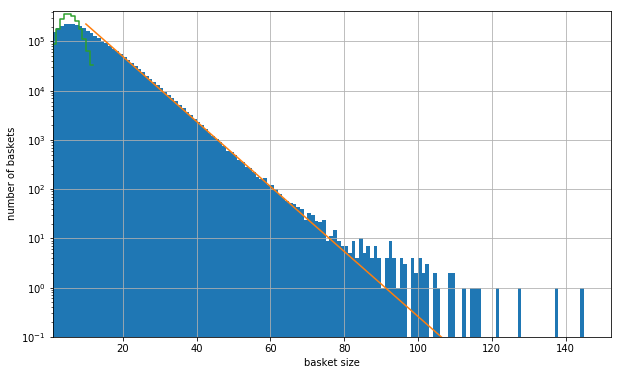

In [68]:
# FIXME: why do I have to do this again? If I don't do this, the figure only 
# shows the exponential fit. This must be some nonsense with the backend behavior ...
pylab.hist(basket_sizes, bins = max_bs - min_bs, log = True)
pylab.xlabel('basket size')
pylab.ylabel('number of baskets')
pylab.xlim(xmin=1)
pylab.ylim(ymin=0.1)
pylab.grid()

bins = np.linspace(sbin, max_bs, max_bs - sbin + 1) # ensure integer bins
pylab.plot(bins, expdist)

pbin = 12 # bin after which we assume Poisson is no good
mu = basket_sizes[basket_sizes <= pbin].mean()
bins = np.linspace(1, pbin, pbin)
poisson = np.array([np.exp(-mu) * mu**k / factorial(k) for k in bins])

# Since 0 is not a valid basket size, we need to renormalize the distribution
# (so it adds to 1). We then rescale the distribution by the given sample size
# to interpret it as the expectation value for a sample of this size
#  i.e., < # baskets of size k > = # baskets * P(k)
poisson = len(basket_sizes[basket_sizes <= pbin]) * poisson / sum(poisson)
pylab.step(bins, poisson)



In [69]:
# I haven't gained much confidence that there's anything Poissonian going
# on here ... so it remains to be seen how we should understand the small
# basket size limit ...